# Imports

In [1]:
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os

In [2]:
# change to src dir
# sys.path.append("/home/javonne/irp-jp2923/src")
sys.path.append("/home/javonne/severity_or_subtype/src")

import functions_data
import functions_abide

# Helpers

# Loading pickles

In [3]:
# pkl_path='/home/javonne/severity_or_subtype/data/abide_ii/smri_data_dimred_1.pkl'
# pkl_path_combat='/home/javonne/severity_or_subtype/data/abide_ii/smri_data_dimred_combat.pkl'
pkl_path='/home/javonne/severity_or_subtype/data/abide_ii/ABIDE_II_SEQUENTIAL_STRUCTURAL_PCA.pkl'
pkl_path_combat='/home/javonne/severity_or_subtype/data/abide_ii/ABIDE_II_SEQUENTIAL_STRUCTURAL_PCA_COMBAT.pkl'
smri_pca = functions_data.load_pickle(pkl_path_combat)
df_special=functions_data.load_pickle(filename="../data/abide_ii/phenotypic_data_special.pkl")


# Clustering

In [20]:
# removing over 16s
mask_YOUNG = df_special["AGE_AT_SCAN "] < 16
mask_ASD = df_special["DX_GROUP"] == 1
# First find the indecies of the autistic patients
ASD_INDECIES = functions_abide.get_dx_indexes(df_special)


## Finding optimal cluster count
### And plotting the first 2 components

In [21]:
smri_pca[mask_ASD & mask_YOUNG].shape

(72, 376)

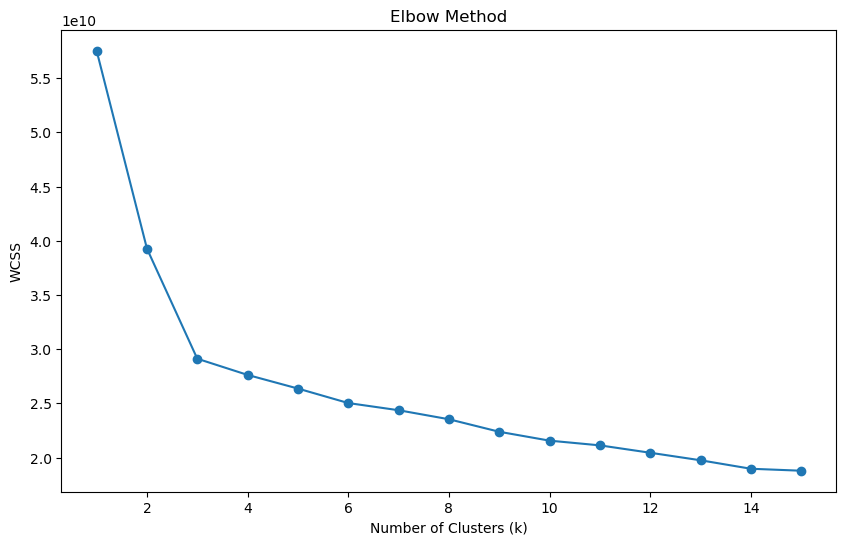

In [22]:
wcss = functions_abide.elbow_plot_clustering(smri_pca[mask_ASD & mask_YOUNG])

In [23]:
optimal_k = functions_abide.find_elbow(wcss)
print(f"The optimal number of clusters appears to be: {optimal_k}")

The optimal number of clusters appears to be: 3


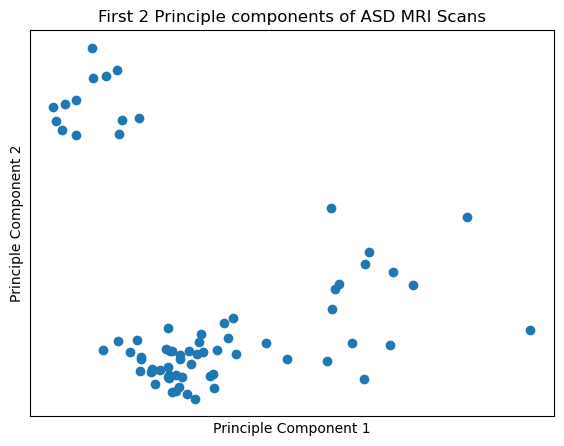

In [24]:
functions_abide.scatter_plot([smri_pca[:, 0][mask_ASD & mask_YOUNG], smri_pca[:, 1][mask_ASD & mask_YOUNG]], xl="Principle Component 1", yl="Principle Component 2", title="First 2 Principle components of ASD MRI Scans")

## Implementing the clustering

## MRI based clustering

In [25]:
# Find the labels for autistic subjects
kmeans = KMeans(n_clusters=3, max_iter=300, n_init=1000, random_state=0).fit(smri_pca[mask_ASD & mask_YOUNG])
# kmeans = KMeans(n_clusters=2, init="k-means++", max_iter=300, n_init=100, random_state=0).fit(smri_pca[ASD_INDECIES])
labels = kmeans.labels_
functions_data.save_pickle("../data/abide_ii/most_recent_labels.pkl", labels)


In [27]:
labels

array([0, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

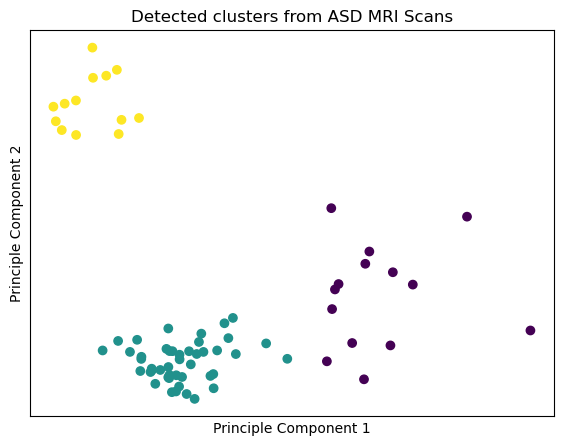

In [26]:
functions_abide.scatter_plot([smri_pca[:, 0][mask_ASD & mask_YOUNG], smri_pca[:, 1][mask_ASD & mask_YOUNG]], 
    xl="Principle Component 1", yl="Principle Component 2", 
    title="Detected clusters from ASD MRI Scans", 
    colours=functions_data.load_pickle("../data/abide_ii/most_recent_labels.pkl"),
)


In [ ]:
:

## Phenotypic clustering

In [ ]:
# CLustering based on Phenotypic data
df_asd = functions_data.load_pickle(filename="../data/abide_ii/phenotypic_data_asd.pkl")
drop_cols=["SITE_ID","DX_GROUP","SRS_EDITION", "SRS_VERSION", "SEX"]
df_asd = df_asd.drop(drop_cols, axis=1).dropna()

In [ ]:
wcss = functions_abide.elbow_plot_clustering(df_asd)
optimal_k = functions_abide.find_elbow(wcss)
print(f"The optimal number of clusters appears to be: {optimal_k}")

In [ ]:
kmeans_phenotypic = KMeans(n_clusters=3).fit(df_asd)
labels_phenotypic = kmeans_phenotypic.labels_

In [ ]:
df_asd["phenotypic_cluster"] = labels_phenotypic

In [ ]:
df_asd["phenotypic_cluster"].describe()

In [ ]:
# Create some masks
mask_cluster_0 = df_asd["phenotypic_cluster"] == 0
mask_cluster_1 = df_asd["phenotypic_cluster"] == 1
mask_cluster_2 = df_asd["phenotypic_cluster"] == 2

# Get allistic subjects as baseline
df_all = functions_data.load_pickle(filename="../data/abide_ii/phenotypic_data_all.pkl")

In [ ]:
for col in df_asd.columns:

    C0_TRAIT = np.array(df_asd[mask_cluster_0][col])
    C1_TRAIT = np.array(df_asd[mask_cluster_1][col])
    C2_TRAIT = np.array(df_asd[mask_cluster_2][col])
    ALL_TRAIT = np.array(df_all[col])
    print(f"The mean {col} of cluster A is {round(np.nanmean(C0_TRAIT[~np.isnan(C0_TRAIT)]),2)} ({round(np.std(C0_TRAIT[~np.isnan(C0_TRAIT)]),2)})")
    print(f"The mean {col} of cluster B is {round(np.nanmean(C1_TRAIT[~np.isnan(C1_TRAIT)]),2)} ({round(np.std(C1_TRAIT[~np.isnan(C1_TRAIT)]),2)})")
    print(f"The mean {col} of cluster C is {round(np.nanmean(C2_TRAIT[~np.isnan(C2_TRAIT)]),2)} ({round(np.std(C2_TRAIT[~np.isnan(C2_TRAIT)]),2)})")
    print(f"The mean {col} of NT SBJCTS is {round(np.nanmean(ALL_TRAIT[~np.isnan(ALL_TRAIT)]),2)} ({round(np.std(ALL_TRAIT[~np.isnan(ALL_TRAIT)]),2)})")
    print()